## Introduction
___
We have discussed overfitting in the context of bias and variance, and we have touched on some techniques that are used to avoid overfitting. In this project, we will practice a fundamental method for avoiding overfitting that is commonly referred to as: three-way split with cross-validation.

This serves two useful purposes:
- We prevent overfitting by not using all of the data.
- We have some remaining data we can use to evaluate our model.

While this may seem like a relatively simple idea, there are some caveats to putting it into practice. For example, if you are not careful, it is easy to take a non-random split. Suppose we have salary data on technical professionals that is composed of 80 percent data from New South Wales, 20 percent data from elsewhere, and is sorted by state. If we split our data into 80 percent training data and 20 percent testing data, we might inadvertantly select all the NSW data to train and all the non-NSW data to test. In this case, we've still overfit on our data set because we did not sufficiently randomise the data.

We have also discussed underfitting and how certain models can be inappropriate for our data or need to be tuned to provide better results. In this project, we will try out different models, compare them against each other and practice hyperparameter tuning.

## Project Objectives
___
The goal of the project is to create multiple machine learning models to make predictions on the dataset containig the results of the Federal Election in Australia in 2016.

To complete this project you will need to solve one regression and one classification problem. In particular, you will need to estimate the turnout at the election and predict which party will receive more votes in each electorate. 

For this project, it is required that you try several models and compare their performance. For example, you could pick two different subsets of variables, one or more polynomial models, or any other model you like. You are also expected to implement both a Logistic Regression and k-Nearest Neighbours to solve the classification task. 

In [1]:
import os
import pandas as pd
import numpy as np
from pandas.api.types import CategoricalDtype
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score, confusion_matrix, roc_curve, roc_auc_score
#from imblearn.over_sampling import SMOTE

%matplotlib inline

pd.options.display.max_columns = 200

plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = (8, 8)
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14

DATA_PATH = './data/'

## Load data

In [2]:
census = pd.read_csv(DATA_PATH + 'Census2016ElectoralDivision.csv')
#census.rename(str.lower, axis='columns', inplace=True)
print(census.shape)
census.head()

(150, 108)


,CED,Family1Child,Family2Children,Family3Children,Family4Children,Family5Children,Family6PlusChildren,FamilyChildrenNA,HHInc_Negative,HHInc_Nil,HHInc_1_149,HHInc_150_299,HHInc_300_399,HHInc_400_499,HHInc_500_649,HHInc_650_799,HHInc_800_999,HHInc_1000_1249,HHInc_1250_1499,HHInc_1500_1749,HHInc_1750_1999,HHInc_2000_2499,HHInc_2500_2999,HHInc_3000_3499,HHInc_3500_3999,HHInc_4000_4499,HHInc_4500_4999,HHInc_5000_5999,HHInc_6000_7999,HHInc_8000_Plus,HHInc_Partial,HHInc_All_incomes_not_stated,HHInc_NA,HHTotal,Rent_Nil,Rent_1_74,Rent_75_99,Rent_100_124,Rent_125_149,Rent_150_174,Rent_175_199,Rent_200_224,Rent_225_249,Rent_250_274,Rent_275_299,Rent_300_324,Rent_325_349,Rent_350_374,Rent_375_399,Rent_400_424,Rent_425_449,Rent_450_549,Rent_550_649,Rent_650_749,Rent_750_849,Rent_850_949,Rent_950_Plus,Rent_Not_stated,Rent_Not_applicable,Age_0_4,Age_5_9,Age_10_14,Age_15_19,Age_20_24,Age_25_29,Age_30_34,Age_35_39,Age_40_44,Age_45_49,Age_50_54,Age_55_59,Age_60_64,Age_65_69,Age_70_74,Age_75_79,Age_80_84,Age_85_89,Age_90_94,Age_95_99,Age_100_Plus,NeverMarried,Widowed,Divorced,Separated,Married,MaritalStatusNA,Male,Female,Population,Ed_Postgraduate_Degree,Ed_Graduate_Diploma_and_Graduate_Certificate,Ed_Bachelor_Degree,Ed_Advanced_Diploma_and_Diploma,Ed_Certificate_III_IV,Ed_Secondary_Education_Years_10_and_above,Ed_Certificate_I_II,Ed_Secondary_Education_Years_9_and_below,Ed_Supplementary_Codes,Ed_Not_stated,Ed_Not_applicable,LabourForceStatus_Employed_worked_FT,LabourForceStatus_Employed_worked_PT,LabourForceStatus_Employed_away_from_work,LabourForceStatus_Unemployed_looking_for_FT,LabourForceStatus_Unemployed_looking_for_PT,LabourForceStatus_Not_in_the_labour_force,LabourForceStatus_Not_stated,LabourForceStatus_Not_applicable
0,Banks,11868,11201,3593,843,180,73,33478,127,831,371,1118,1604,3116,1983,3291,2964,3848,3509,3039,2959,5994,3850,2691,2148,1215,1166,1115,795,140,3937,1243,5249,58297,402,206,195,1216,316,539,298,510,216,325,197,502,289,778,789,1582,845,3866,1813,771,243,60,79,613,41643,9444,9250,8722,9422,10688,11555,11461,10286,10387,10195,10602,10141,8551,7236,5457,4481,3668,2636,1311,285,29,40570,7554,9819,3532,66927,27413,75780,80031,155804,8333,1948,22905,12431,15745,41077,64,10355,5982,9559,27413,46085,23083,3557,2418,2403,45079,5770,27413
1,Barton,13019,10308,3238,871,177,69,41666,168,1347,536,1151,1437,3016,1939,3596,3406,4297,4108,3577,3423,6820,4293,3038,2416,1220,1155,1023,727,91,4542,1123,7427,65885,577,98,88,519,151,311,195,406,247,382,233,652,371,972,819,1912,1090,5860,4075,1344,438,192,220,685,44066,10307,9145,8112,9044,13661,18197,16774,12999,11684,10762,10294,9141,8050,6931,5375,4636,3752,2499,1187,288,17,52564,7055,10055,3945,71671,27569,85725,87130,172852,11693,2173,28881,13387,13648,43563,48,11617,6954,13331,27569,52297,26219,4158,2957,2884,47775,8992,27569
2,Bennelong,12778,11897,3284,571,81,19,38867,163,1461,509,1055,1250,2644,1862,2870,2978,4012,3778,3446,3275,6680,4401,3189,3158,1745,1751,1751,1478,238,4341,1072,6232,65322,518,162,139,685,221,401,251,388,279,406,198,489,394,941,841,1628,1094,5124,3422,1747,691,333,338,693,43923,10216,9709,8479,9619,13513,14286,14382,12875,11552,10754,10823,9819,8701,7145,5074,4301,3473,2654,1253,296,23,48572,6615,8445,2795,74121,28399,82362,86578,168948,17086,3045,35865,13314,11803,37442,58,7136,5692,9112,28399,53794,24530,3651,2673,2920,47155,5819,28399
3,Berowra,9604,12304,4227,946,156,68,24731,63,418,272,503,630,1630,1245,1952,1990,2636,2522,2123,2268,4786,3699,3015,3018,2075,2167,2158,1806,317,4202,739,3993,50228,311,47,38,172,74,88,84,140,82,118,105,213,85,177,123,277,146,1070,1288,895,470,233,209,293,43493,7745,10055,10200,10565,8899,6182,6545,8512,10666,11109,11018,10278,8708,7806,5974,4294,2938,2148,1159,317,20,32587,5727,6671,2142,70012,28000,71298,73836,145132,10987,3206,27253,12612,13457,31440,51,5775,4852,7493,28000,45216,24034,3046,1587,1733,36866,4655,28000
4,Blaxland,11650,10429,5160,2172,693,341,30545,209,1017,435,1496,1845,3457,2513,3966,3757,4403,3824,3035,2658,4

In [3]:
results = pd.read_csv(DATA_PATH + 'ElectionResults2016.csv')
#results.rename(str.lower, axis='columns', inplace=True)
print(results.shape)
results.head()

(150, 57)


,CED,DivisionID,State,Enrolment,Turnout,WinningParty,ALP,LP,LNP,NP,GRN,IND,AAPP,ADVP,AEQ,AFN,AJP,ALA,ARF,ARTS,ASP,ASXP,AUC,AUP,BTA,CDP,CEC,CLP,CM,CRNT,CYA,CYC,DHJP,DLP,DRF,FFP,FUT,GLT,HMP,KAP,LDP,MAP,NCP,None,ODR,ON,PIR,PUP,REP,RUA,SAL,SEP,SMK,SOL,SPP,VEP,XEN
0,Canberra,101,ACT,143231,128720,ALP,75247,53473,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Fenner,102,ACT,138814,124022,ALP,79242,44780,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Banks,103,NSW,104891,89832,LP,43622,46210,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Barton,104,NSW,106511,87702,ALP,51131,36571,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Bennelong,105,NSW,105962,92231,LP,37154,55077,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [4]:
parties = pd.read_csv(DATA_PATH + 'Parties2016.csv')
print(parties.shape)
parties.head()

(51, 2)


,Party,PartyName
0,ALP,Australian Labor Party
1,GRN,The Greens
2,BTA,Bullet Train For Australia
3,LP,Liberal
4,IND,Independent


## Exploratory Data Analysis

### Census dataset

In [5]:
census.dtypes.value_counts()

int64     107
object      1
dtype: int64

In [6]:
census.dtypes.head()

CED                object
Family1Child        int64
Family2Children     int64
Family3Children     int64
Family4Children     int64
dtype: object

In [7]:
list(census.columns)

['CED',
 'Family1Child',
 'Family2Children',
 'Family3Children',
 'Family4Children',
 'Family5Children',
 'Family6PlusChildren',
 'FamilyChildrenNA',
 'HHInc_Negative',
 'HHInc_Nil',
 'HHInc_1_149',
 'HHInc_150_299',
 'HHInc_300_399',
 'HHInc_400_499',
 'HHInc_500_649',
 'HHInc_650_799',
 'HHInc_800_999',
 'HHInc_1000_1249',
 'HHInc_1250_1499',
 'HHInc_1500_1749',
 'HHInc_1750_1999',
 'HHInc_2000_2499',
 'HHInc_2500_2999',
 'HHInc_3000_3499',
 'HHInc_3500_3999',
 'HHInc_4000_4499',
 'HHInc_4500_4999',
 'HHInc_5000_5999',
 'HHInc_6000_7999',
 'HHInc_8000_Plus',
 'HHInc_Partial',
 'HHInc_All_incomes_not_stated',
 'HHInc_NA',
 'HHTotal',
 'Rent_Nil',
 'Rent_1_74',
 'Rent_75_99',
 'Rent_100_124',
 'Rent_125_149',
 'Rent_150_174',
 'Rent_175_199',
 'Rent_200_224',
 'Rent_225_249',
 'Rent_250_274',
 'Rent_275_299',
 'Rent_300_324',
 'Rent_325_349',
 'Rent_350_374',
 'Rent_375_399',
 'Rent_400_424',
 'Rent_425_449',
 'Rent_450_549',
 'Rent_550_649',
 'Rent_650_749',
 'Rent_750_849',
 'Rent_85

**The dataset contains the following information about each electorate:**
- Name of the Commonwealth Electorate Division (CED)
- Aggregated data
    - Number of children in a family
    - Total household income
    - Weekly rent
- Individual data
    - Age
    - Marital status
    - Gender and total population
    - Level of education
    - Labour force status

###### Are there any missing values?

In [8]:
census.isnull().sum().sum()

0

###### Summary statistics

In [9]:
census.describe()

,Family1Child,Family2Children,Family3Children,Family4Children,Family5Children,Family6PlusChildren,FamilyChildrenNA,HHInc_Negative,HHInc_Nil,HHInc_1_149,HHInc_150_299,HHInc_300_399,HHInc_400_499,HHInc_500_649,HHInc_650_799,HHInc_800_999,HHInc_1000_1249,HHInc_1250_1499,HHInc_1500_1749,HHInc_1750_1999,HHInc_2000_2499,HHInc_2500_2999,HHInc_3000_3499,HHInc_3500_3999,HHInc_4000_4499,HHInc_4500_4999,HHInc_5000_5999,HHInc_6000_7999,HHInc_8000_Plus,HHInc_Partial,HHInc_All_incomes_not_stated,HHInc_NA,HHTotal,Rent_Nil,Rent_1_74,Rent_75_99,Rent_100_124,Rent_125_149,Rent_150_174,Rent_175_199,Rent_200_224,Rent_225_249,Rent_250_274,Rent_275_299,Rent_300_324,Rent_325_349,Rent_350_374,Rent_375_399,Rent_400_424,Rent_425_449,Rent_450_549,Rent_550_649,Rent_650_749,Rent_750_849,Rent_850_949,Rent_950_Plus,Rent_Not_stated,Rent_Not_applicable,Age_0_4,Age_5_9,Age_10_14,Age_15_19,Age_20_24,Age_25_29,Age_30_34,Age_35_39,Age_40_44,Age_45_49,Age_50_54,Age_55_59,Age_60_64,Age_65_69,Age_70_74,Age_75_79,Age_80_84,Age_85_89,Age_90_94,Age_95_99,Age_100_Plus,NeverMarried,Widowed,Divorced,Separated,Married,MaritalStatusNA,Male,Female,Population,Ed_Postgraduate_Degree,Ed_Graduate_Diploma_and_Graduate_Certificate,Ed_Bachelor_Degree,Ed_Advanced_Diploma_and_Diploma,Ed_Certificate_III_IV,Ed_Secondary_Education_Years_10_and_above,Ed_Certificate_I_II,Ed_Secondary_Education_Years_9_and_below,Ed_Supplementary_Codes,Ed_Not_stated,Ed_Not_applicable,LabourForceStatus_Employed_worked_FT,LabourForceStatus_Employed_worked_PT,LabourForceStatus_Employed_away_from_work,LabourForceStatus_Unemployed_looking_for_FT,LabourForceStatus_Unemployed_looking_for_PT,LabourForceStatus_Not_in_the_labour_force,LabourForceStatus_Not_stated,LabourForceStatus_Not_applicable
count,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.00000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.00000,150.000000,150.000000,150.00000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.00000,150.000000,150.000000,150.000000,150.000000,150.000000
mean,10172.173333,9564.186667,3503.900000,941.866667,216.520000,106.626667,39277.80000,143.513333,776.593333,423.380000,1144.413333,1570.133333,3611.080000,2426.006667,3959.773333,3687.220000,4487.940000,4036.766667,3288.820000,3132.066667,5848.980000,3576.846667,2329.106667,2095.686667,1034.680000,993.700000,913.306667,771.793333,104.353333,4332.213333,1541.273333,9934.413333,66164.440000,557.800000,260.153333,244.846667,736.633333,338.346667,623.826667,490.733333,804.100000,573.680000,1042.933333,825.213333,1458.613333,899.093333,1388.173333,887.913333,1181.053333,520.926667,1947.413333,926.460000,466.553333,240.073333,130.126667,249.660000,583.373333,48787.013333,9755.453333,10010.446667,9309.126667,9465.420000,10415.033333,11060.900000,11330.260000,10388.020000,10532.440000,10521.12000,10133.693333,9672.553333,8638.46000,7904.280000,5906.600000,4345.793333,3068.306667,2058.860000,935.773333,225.933333,23.780000,44311.093333,6560.420000,10809.186667,4033.400000,60913.726667,29075.166667,76798.346667,78905.346667,155703.593333,6132.640000,2513.846667,19189.633333,11234

**Ideally, values across each group (i.e Age, Gender, Marital Status, etc) should sum up to the value in Population column. Let's look at the first row and check if there are any errors.**

In [10]:
banks = census.iloc[[0]]
banks

,CED,Family1Child,Family2Children,Family3Children,Family4Children,Family5Children,Family6PlusChildren,FamilyChildrenNA,HHInc_Negative,HHInc_Nil,HHInc_1_149,HHInc_150_299,HHInc_300_399,HHInc_400_499,HHInc_500_649,HHInc_650_799,HHInc_800_999,HHInc_1000_1249,HHInc_1250_1499,HHInc_1500_1749,HHInc_1750_1999,HHInc_2000_2499,HHInc_2500_2999,HHInc_3000_3499,HHInc_3500_3999,HHInc_4000_4499,HHInc_4500_4999,HHInc_5000_5999,HHInc_6000_7999,HHInc_8000_Plus,HHInc_Partial,HHInc_All_incomes_not_stated,HHInc_NA,HHTotal,Rent_Nil,Rent_1_74,Rent_75_99,Rent_100_124,Rent_125_149,Rent_150_174,Rent_175_199,Rent_200_224,Rent_225_249,Rent_250_274,Rent_275_299,Rent_300_324,Rent_325_349,Rent_350_374,Rent_375_399,Rent_400_424,Rent_425_449,Rent_450_549,Rent_550_649,Rent_650_749,Rent_750_849,Rent_850_949,Rent_950_Plus,Rent_Not_stated,Rent_Not_applicable,Age_0_4,Age_5_9,Age_10_14,Age_15_19,Age_20_24,Age_25_29,Age_30_34,Age_35_39,Age_40_44,Age_45_49,Age_50_54,Age_55_59,Age_60_64,Age_65_69,Age_70_74,Age_75_79,Age_80_84,Age_85_89,Age_90_94,Age_95_99,Age_100_Plus,NeverMarried,Widowed,Divorced,Separated,Married,MaritalStatusNA,Male,Female,Population,Ed_Postgraduate_Degree,Ed_Graduate_Diploma_and_Graduate_Certificate,Ed_Bachelor_Degree,Ed_Advanced_Diploma_and_Diploma,Ed_Certificate_III_IV,Ed_Secondary_Education_Years_10_and_above,Ed_Certificate_I_II,Ed_Secondary_Education_Years_9_and_below,Ed_Supplementary_Codes,Ed_Not_stated,Ed_Not_applicable,LabourForceStatus_Employed_worked_FT,LabourForceStatus_Employed_worked_PT,LabourForceStatus_Employed_away_from_work,LabourForceStatus_Unemployed_looking_for_FT,LabourForceStatus_Unemployed_looking_for_PT,LabourForceStatus_Not_in_the_labour_force,LabourForceStatus_Not_stated,LabourForceStatus_Not_applicable
0,Banks,11868,11201,3593,843,180,73,33478,127,831,371,1118,1604,3116,1983,3291,2964,3848,3509,3039,2959,5994,3850,2691,2148,1215,1166,1115,795,140,3937,1243,5249,58297,402,206,195,1216,316,539,298,510,216,325,197,502,289,778,789,1582,845,3866,1813,771,243,60,79,613,41643,9444,9250,8722,9422,10688,11555,11461,10286,10387,10195,10602,10141,8551,7236,5457,4481,3668,2636,1311,285,29,40570,7554,9819,3532,66927,27413,75780,80031,155804,8333,1948,22905,12431,15745,41077,64,10355,5982,9559,27413,46085,23083,3557,2418,2403,45079,5770,27413


In [11]:
# Columns containing age
age_cols = [col for col in banks.columns if 'Age' in col]
for age, num in zip(age_cols, banks[age_cols].values.T):
    print(age, num)

Age_0_4 [9444]
Age_5_9 [9250]
Age_10_14 [8722]
Age_15_19 [9422]
Age_20_24 [10688]
Age_25_29 [11555]
Age_30_34 [11461]
Age_35_39 [10286]
Age_40_44 [10387]
Age_45_49 [10195]
Age_50_54 [10602]
Age_55_59 [10141]
Age_60_64 [8551]
Age_65_69 [7236]
Age_70_74 [5457]
Age_75_79 [4481]
Age_80_84 [3668]
Age_85_89 [2636]
Age_90_94 [1311]
Age_95_99 [285]
Age_100_Plus [29]


In [12]:
# Sum of all columns containing age
banks[age_cols].sum(axis=1)

0    155807
dtype: int64

In [13]:
print("Total population in {} is {}.".format(banks.loc[0, 'CED'], banks.loc[0, 'Population']))

Total population in Banks is 155804.


In [14]:
diff = (banks.Population - banks[age_cols].sum(axis=1)).values
print("The difference between the totals is", int(diff))

The difference between the totals is -3


** Due to unknown reason, we have three additional individuals. Let's subtract this number from one of the columns so that the sum across the Age columns equals the value in the Population column.**

In [15]:
majority = banks[age_cols].values.max()
for col in age_cols:
    if banks.loc[0, col] == majority:
        banks.loc[0, col] = banks.loc[0, col] + diff

C:\Users\Yoshi\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [16]:
banks.loc[0,'Age_25_29']

11552

###### Correct values in the entire dataset

In [17]:
def correct_values(df):
    age_cols = [col for col in df.columns if 'Age' in col]
    marriage_cols = ['NeverMarried', 'Widowed', 'Divorced', 'Separated', 'Married', 'MaritalStatusNA']
    gender_cols = ['Male', 'Female']
    ed_cols = [col for col in df.columns if 'Ed' in col]
    empl_cols = [col for col in df.columns if 'LabourForceStatus' in col]

    columns = [age_cols, marriage_cols, gender_cols, ed_cols, empl_cols]
    for i in range(len(columns)):
        diff = df.Population - df[columns[i]].sum(axis=1)
        majority = df[columns[i]].max(axis=1)
        for col in columns[i]:
            df[col] += diff * (df[col] == majority)
    return df

In [18]:
correct_values(census)

# Check if the totals are equal now.
(census[age_cols].sum(axis=1) != census.Population).sum()

0

(107, 107)


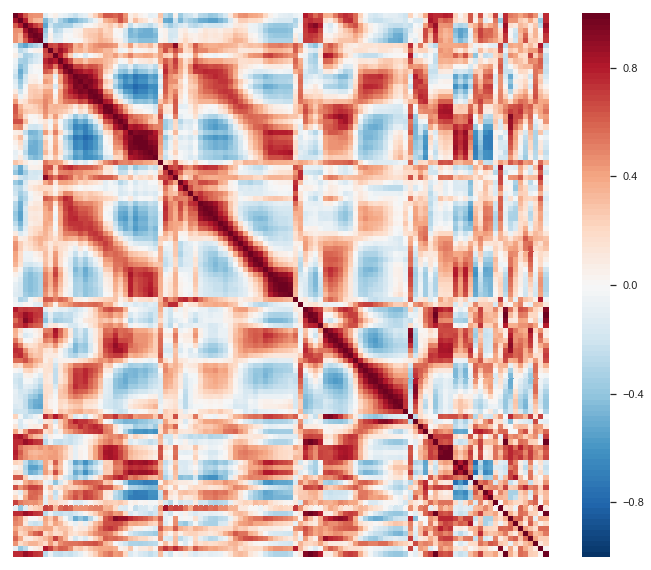

In [19]:
correlations = census.corr()
print(correlations.shape)

sns.set(rc={'figure.figsize':(12, 10)})

sns.heatmap(correlations, 
            vmin=-1, vmax=1, 
            cmap=sns.color_palette("RdBu_r", 100), 
            xticklabels=False, yticklabels=False);

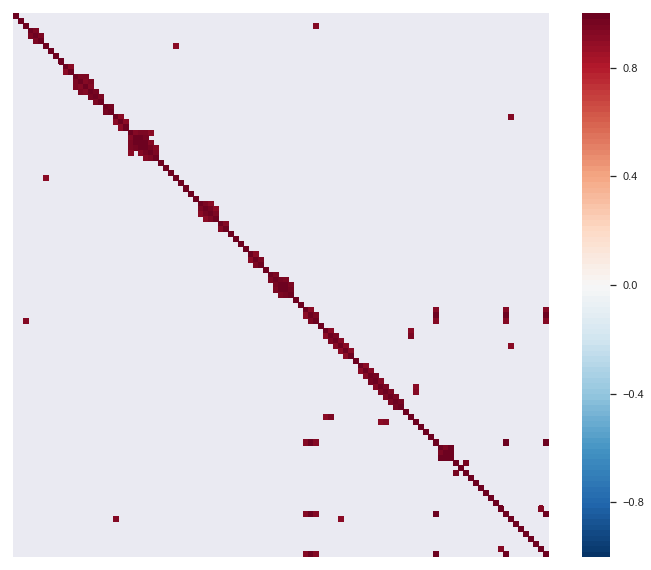

In [20]:
mask = np.zeros_like(correlations)
mask[abs(correlations) < 0.9] = 1

sns.heatmap(correlations,
            vmin=-1, vmax=1, mask=mask,
            cmap=sns.color_palette("RdBu_r", 100),
            xticklabels=False, yticklabels=False);

### Results dataset

In [21]:
results.dtypes.value_counts()

int64     54
object     3
dtype: int64

In [22]:
results.dtypes.head(10)

CED             object
DivisionID       int64
State           object
Enrolment        int64
Turnout          int64
WinningParty    object
ALP              int64
LP               int64
LNP              int64
NP               int64
dtype: object

In [23]:
list(results.columns)

['CED',
 'DivisionID',
 'State',
 'Enrolment',
 'Turnout',
 'WinningParty',
 'ALP',
 'LP',
 'LNP',
 'NP',
 'GRN',
 'IND',
 'AAPP',
 'ADVP',
 'AEQ',
 'AFN',
 'AJP',
 'ALA',
 'ARF',
 'ARTS',
 'ASP',
 'ASXP',
 'AUC',
 'AUP',
 'BTA',
 'CDP',
 'CEC',
 'CLP',
 'CM',
 'CRNT',
 'CYA',
 'CYC',
 'DHJP',
 'DLP',
 'DRF',
 'FFP',
 'FUT',
 'GLT',
 'HMP',
 'KAP',
 'LDP',
 'MAP',
 'NCP',
 'None',
 'ODR',
 'ON',
 'PIR',
 'PUP',
 'REP',
 'RUA',
 'SAL',
 'SEP',
 'SMK',
 'SOL',
 'SPP',
 'VEP',
 'XEN']

**The dataset contains the following information about each electorate:**
- Name of the Commonwealth Electorate Division (CED)
- A unique ID
- State
- Enrolment and turnout at the election
- Winning party
- The rest 51 columns contain numbers of votes received by each party

###### Are there any missing values?

In [24]:
results.isnull().sum().sum()

0

###### Summary statistics

In [25]:
results.describe(include='all')

,CED,DivisionID,State,Enrolment,Turnout,WinningParty,ALP,LP,LNP,NP,GRN,IND,AAPP,ADVP,AEQ,AFN,AJP,ALA,ARF,ARTS,ASP,ASXP,AUC,AUP,BTA,CDP,CEC,CLP,CM,CRNT,CYA,CYC,DHJP,DLP,DRF,FFP,FUT,GLT,HMP,KAP,LDP,MAP,NCP,None,ODR,ON,PIR,PUP,REP,RUA,SAL,SEP,SMK,SOL,SPP,VEP,XEN
count,150,150.000000,150,150.000000,150.000000,150,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.0,150.0,150.0,150.0,150.0,150.0,150.0,150.0,150.0,150.0,150.0,150.0,150.0,150.0,150.0,150.000000,150.0,150.0,150.0,150.0,150.0,150.0,150.0,150.0,150.0,150.0,150.0,150.000000,150.0,150.0,150.0,150.0,150.0,150.000000,150.0,150.0,150.0,150.0,150.0,150.0,150.0,150.0,150.0,150.0,150.000000
unique,150,NaN,8,NaN,NaN,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,Fadden,NaN,NSW,NaN,NaN,ALP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,47,NaN,NaN,69,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,188.820000,NaN,104477.006667,90274.006667,NaN,41404.713333,30008.333333,9520.360000,4468.680000,1684.393333,1206.820000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,278.973333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,350.466667,0.0,0.0,0.0,0.0,0.0,204.940000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1146.326667
std,NaN,55.471992,NaN,10054.470041,9618.098112,NaN,16371.423529,22276.560686,19391.393947,15383.386693,8581.123207,7340.478748,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2434.429183,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4292.322526,0.0,0.0,0.0,0.0,0.0,2509.992139,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7031.385276
min,NaN,101.000000,NaN,63131.000000,42875.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
25%,NaN,145.250000,NaN,100363.250000,86195.000000,NaN,34169.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
50%,NaN,186.500000,NaN,104874.000000,90202.500000,NaN,42778.500000,37208.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
75%,NaN,225.750000,NaN,109182.000000,94717.750000,NaN,51915.250000,47700.750000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


###### Explore distributions

In [26]:
results.DivisionID.value_counts().max()
results.drop('DivisionID', axis=1, inplace=True)

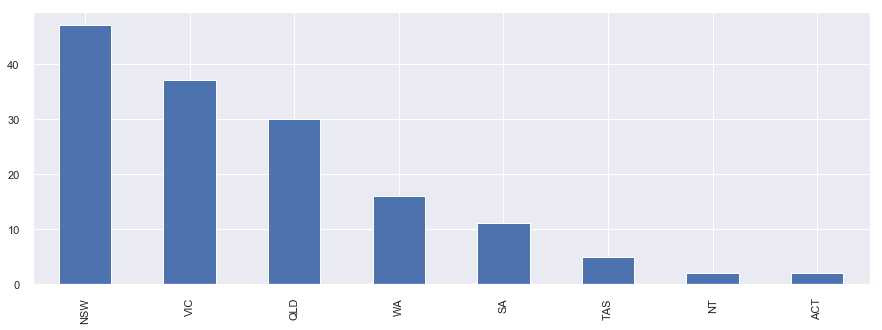

In [27]:
results.State.value_counts().plot(kind='bar', figsize=(15, 5));

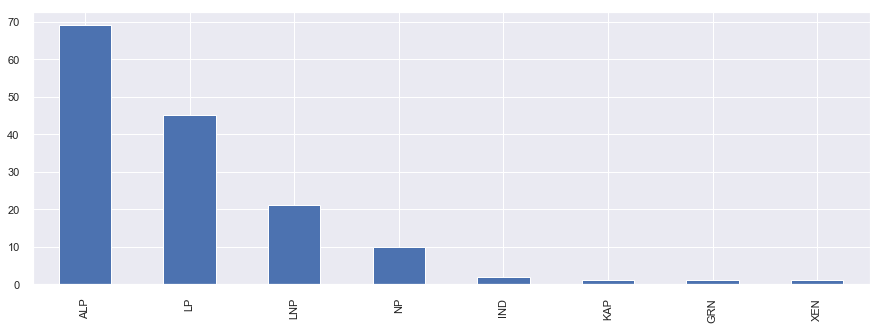

In [28]:
results.WinningParty.value_counts().plot(kind='bar', figsize=(15, 5));

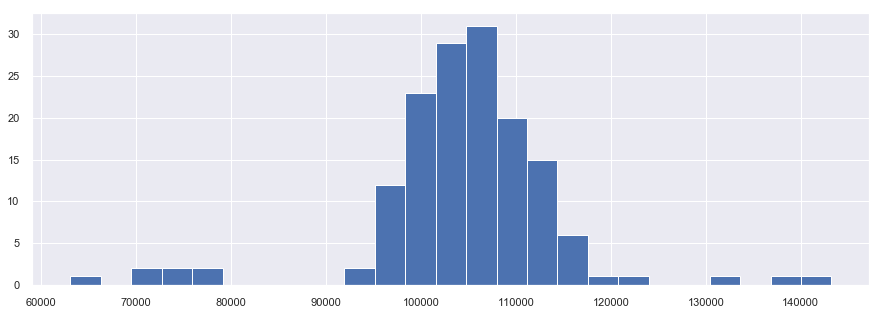

In [29]:
results.Enrolment.hist(bins=25, figsize=(15, 5));

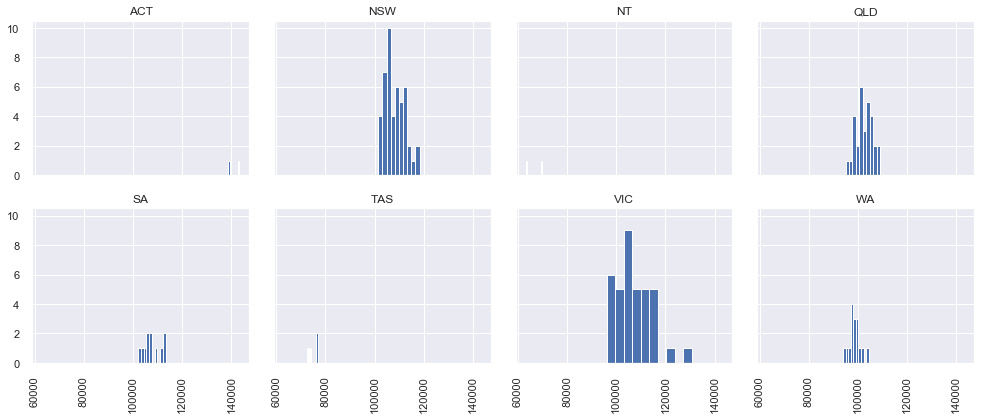

In [30]:
results.hist(column='Enrolment', by='State', sharex=True, sharey=True, layout=(2, 4), figsize=(14, 6));
plt.tight_layout()

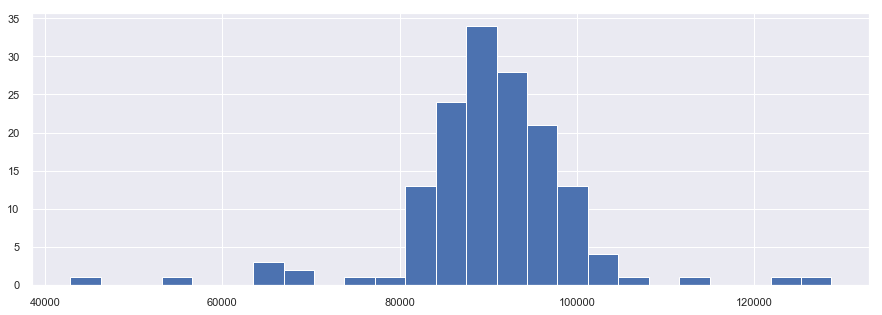

In [31]:
results.Turnout.hist(bins=25, figsize=(15, 5));

###### Are there any outliers and should they be excluded?

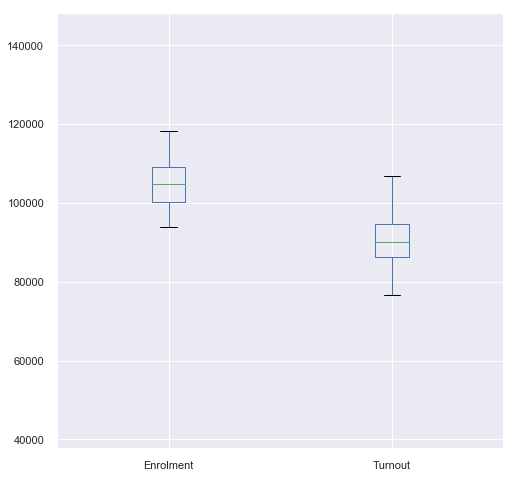

In [32]:
results[['Enrolment','Turnout']].boxplot(figsize=(8, 8));

###### Create a combined dataset

In [33]:
election = pd.merge(census, results, how="outer", on="CED")
print(election.shape)
election.head()

(150, 163)


,CED,Family1Child,Family2Children,Family3Children,Family4Children,Family5Children,Family6PlusChildren,FamilyChildrenNA,HHInc_Negative,HHInc_Nil,HHInc_1_149,HHInc_150_299,HHInc_300_399,HHInc_400_499,HHInc_500_649,HHInc_650_799,HHInc_800_999,HHInc_1000_1249,HHInc_1250_1499,HHInc_1500_1749,HHInc_1750_1999,HHInc_2000_2499,HHInc_2500_2999,HHInc_3000_3499,HHInc_3500_3999,HHInc_4000_4499,HHInc_4500_4999,HHInc_5000_5999,HHInc_6000_7999,HHInc_8000_Plus,HHInc_Partial,HHInc_All_incomes_not_stated,HHInc_NA,HHTotal,Rent_Nil,Rent_1_74,Rent_75_99,Rent_100_124,Rent_125_149,Rent_150_174,Rent_175_199,Rent_200_224,Rent_225_249,Rent_250_274,Rent_275_299,Rent_300_324,Rent_325_349,Rent_350_374,Rent_375_399,Rent_400_424,Rent_425_449,Rent_450_549,Rent_550_649,Rent_650_749,Rent_750_849,Rent_850_949,Rent_950_Plus,Rent_Not_stated,Rent_Not_applicable,Age_0_4,Age_5_9,Age_10_14,Age_15_19,Age_20_24,Age_25_29,Age_30_34,Age_35_39,Age_40_44,Age_45_49,Age_50_54,Age_55_59,Age_60_64,Age_65_69,Age_70_74,Age_75_79,Age_80_84,Age_85_89,Age_90_94,Age_95_99,Age_100_Plus,NeverMarried,Widowed,Divorced,Separated,Married,MaritalStatusNA,Male,Female,Population,Ed_Postgraduate_Degree,Ed_Graduate_Diploma_and_Graduate_Certificate,Ed_Bachelor_Degree,Ed_Advanced_Diploma_and_Diploma,Ed_Certificate_III_IV,Ed_Secondary_Education_Years_10_and_above,Ed_Certificate_I_II,Ed_Secondary_Education_Years_9_and_below,Ed_Supplementary_Codes,Ed_Not_stated,Ed_Not_applicable,LabourForceStatus_Employed_worked_FT,LabourForceStatus_Employed_worked_PT,LabourForceStatus_Employed_away_from_work,LabourForceStatus_Unemployed_looking_for_FT,LabourForceStatus_Unemployed_looking_for_PT,LabourForceStatus_Not_in_the_labour_force,LabourForceStatus_Not_stated,LabourForceStatus_Not_applicable,State,Enrolment,Turnout,WinningParty,ALP,LP,LNP,NP,GRN,IND,AAPP,ADVP,AEQ,AFN,AJP,ALA,ARF,ARTS,ASP,ASXP,AUC,AUP,BTA,CDP,CEC,CLP,CM,CRNT,CYA,CYC,DHJP,DLP,DRF,FFP,FUT,GLT,HMP,KAP,LDP,MAP,NCP,None,ODR,ON,PIR,PUP,REP,RUA,SAL,SEP,SMK,SOL,SPP,VEP,XEN
0,Banks,11868,11201,3593,843,180,73,33478,127,831,371,1118,1604,3116,1983,3291,2964,3848,3509,3039,2959,5994,3850,2691,2148,1215,1166,1115,795,140,3937,1243,5249,58297,402,206,195,1216,316,539,298,510,216,325,197,502,289,778,789,1582,845,3866,1813,771,243,60,79,613,41643,9444,9250,8722,9422,10688,11552,11461,10286,10387,10195,10602,10141,8551,7236,5457,4481,3668,2636,1311,285,29,40570,7554,9819,3532,66916,27413,75780,80024,155804,8333,1948,22905,12431,15745,41069,64,10355,5982,9559,27413,46081,23083,3557,2418,2403,45079,5770,27413,NSW,104891,89832,LP,43622,46210,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Barton,13019,10308,3238,871,177,69,41666,168,1347,536,1151,1437,3016,1939,3596,3406,4297,4108,3577,3423,6820,4293,3038,2416,1220,1155,1023,727,91,4542,1123,7427,65885,577,98,88,519,151,311,195,406,247,382,233,652,371,972,819,1912,1090,5860,4075,1344,438,192,220,685,44066,10307,9145,8112,9044,13661,18194,16774,12999,11684,10762,10294,9141,8050,6931,5375,4636,3752,2499,1187,288,17,52564,7055,10055,3945,71664,27569,85725,87127,172852,11693,2173,28881,13387,13648,43551,48,11617,6954,13331,27569,52298,26219,4158,2957,2884,47775,8992,27569,NSW,106511,87702,ALP,51131,36571,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Bennelong,12778,11897,3284,571,81,19,38867,163,1461,509,1055,1250,2644,1862,2870,2978,4012,3778,3446,3275,6680,4401,3189,3158,1745,1751,1751,1478,238,4341,1072,6232,65322,518,162,139,685,221,401,251,388,279,406,198,489,394,941,841,1628,1094,5124,3422,1747,691,333,338,693,43923,10216,9709,8479,9619,13513,14286,14383,12875,11552,10754,10823,9819,8701,7145,5074,4301,3473,2654,1253,296,23,48572,6615,8445,2795,74122,28399,82362,86586,168948,17086,3045,35865,13314,11803,37438,58,7136,5692,9112,28399,53801,24530,3651,2673,2920,47155,5819,28399,NSW,105962,92231,LP,37154,55077,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,B

In [34]:
election.to_csv('./data/ElectionCombined.csv')

## Regression

**Objective: Using the available data predict turnout at the election.**

**Basic level**
- Explore the relationships between the features.
- Select or engineer features that are assocciated with the response variable.
- Create one-hot vectors for categorical variables.
- Create a train/test split (try different ratios).
- Standartise the dataset if needed.
- Train and evaluate a regression model.
- Use a dummy estimator to compare your model against it.

**Intermediate level**
- Decide if you should fit the intercept.
- Try high degree polynomials (all variables, some variables or interaction terms only).
- Create train-validation-test split to tune your model.

**Advanced level**
- Use three-way split with cross-validation.
- Try regularisation techniques.

### Create a new dataframe containing pre election data

In [35]:
pre_election = election.loc[:, 'CED' : 'Turnout']

In [36]:
list(pre_election.columns)

['CED',
 'Family1Child',
 'Family2Children',
 'Family3Children',
 'Family4Children',
 'Family5Children',
 'Family6PlusChildren',
 'FamilyChildrenNA',
 'HHInc_Negative',
 'HHInc_Nil',
 'HHInc_1_149',
 'HHInc_150_299',
 'HHInc_300_399',
 'HHInc_400_499',
 'HHInc_500_649',
 'HHInc_650_799',
 'HHInc_800_999',
 'HHInc_1000_1249',
 'HHInc_1250_1499',
 'HHInc_1500_1749',
 'HHInc_1750_1999',
 'HHInc_2000_2499',
 'HHInc_2500_2999',
 'HHInc_3000_3499',
 'HHInc_3500_3999',
 'HHInc_4000_4499',
 'HHInc_4500_4999',
 'HHInc_5000_5999',
 'HHInc_6000_7999',
 'HHInc_8000_Plus',
 'HHInc_Partial',
 'HHInc_All_incomes_not_stated',
 'HHInc_NA',
 'HHTotal',
 'Rent_Nil',
 'Rent_1_74',
 'Rent_75_99',
 'Rent_100_124',
 'Rent_125_149',
 'Rent_150_174',
 'Rent_175_199',
 'Rent_200_224',
 'Rent_225_249',
 'Rent_250_274',
 'Rent_275_299',
 'Rent_300_324',
 'Rent_325_349',
 'Rent_350_374',
 'Rent_375_399',
 'Rent_400_424',
 'Rent_425_449',
 'Rent_450_549',
 'Rent_550_649',
 'Rent_650_749',
 'Rent_750_849',
 'Rent_85

###### Define lists of column names

In [37]:
fam_cols = [col for col in pre_election.columns if 'Family' in col]
inc_cols = [col for col in pre_election.columns if 'HHInc' in col]
rent_cols = [col for col in pre_election.columns if 'Rent' in col]
age_cols = [col for col in pre_election.columns if 'Age' in col]
mar_cols = ['NeverMarried', 'Widowed', 'Divorced', 'Separated', 'Married', 'MaritalStatusNA']
gender_cols = ['Male', 'Female']
ed_cols = [col for col in pre_election.columns if 'Ed' in col]
empl_cols = [col for col in pre_election.columns if 'LabourForceStatus' in col]

Plus, I have a `Population` column, an `HHTotal`, a `State` column that I'm going to transform into one-hot vectors, `Enrolment` and `Turnout`.

### Target variable

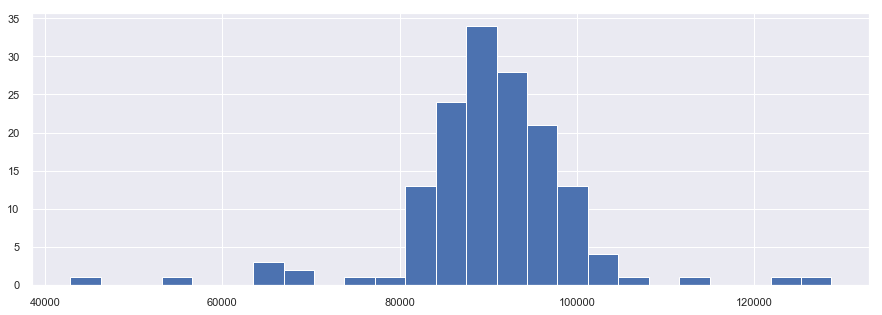

In [38]:
pre_election.Turnout.hist(bins=25, figsize=(15, 5));

In [39]:
pre_election.Turnout.mean()

90274.00666666667

### Transform the `State` variable

In [40]:
state_dummies = pd.get_dummies(election.State)
state_dummies.drop(columns="NSW", inplace=True)
state_cols = state_dummies.columns
state_dummies.head()

,ACT,NT,QLD,SA,TAS,VIC,WA
0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0


In [41]:
# pre_election = pd.concat([pre_election, state_dummies], axis=1)
# pre_election.drop('State', axis=1, inplace=True)

### Normalise data by sum / population

In [42]:
total = pre_election[fam_cols].sum(axis=1)
for col in fam_cols:
    pre_election[col] = pre_election[col] / total

    
# HHTotal doesn't correspond to the sum across incom columns
# I'm going to drop it and normalise by the actual sum.
pre_election.drop('HHTotal', axis=1, inplace=True)

total = pre_election[inc_cols].sum(axis=1)
for col in inc_cols:
    pre_election[col] = pre_election[col] / total
    
    
total = pre_election[rent_cols].sum(axis=1)
for col in rent_cols:
    pre_election[col] = pre_election[col] / total

    
# Normalise individual data by Population.    
cols = pre_election.loc[:, 'Age_0_4' : 'LabourForceStatus_Not_applicable'].drop('Population', axis=1).columns
for col in cols:
    pre_election[col] = pre_election[col] / pre_election.Population

### Correlation with the target variable

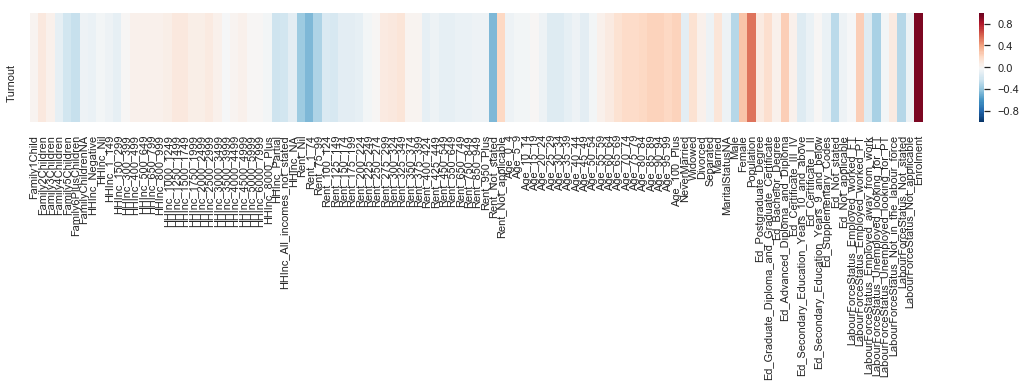

In [43]:
correlations = pre_election.corr()

sns.set(rc={'figure.figsize':(20, 2)})

sns.heatmap(correlations[['Turnout']].drop('Turnout').T, 
            vmin=-1, vmax=1,
            cmap=sns.color_palette("RdBu_r", 100), 
            xticklabels=True, yticklabels=True);

In [44]:
feature_cols = abs(correlations.Turnout).drop('Turnout').sort_values(ascending=False).head(5).index.to_list()
feature_cols

['Enrolment', 'Population', 'Rent_Not_stated', 'Rent_1_74', 'Rent_Nil']

In [45]:
# sns.pairplot(pd.concat([pre_election[feature_cols], pre_election.Turnout], axis=1));

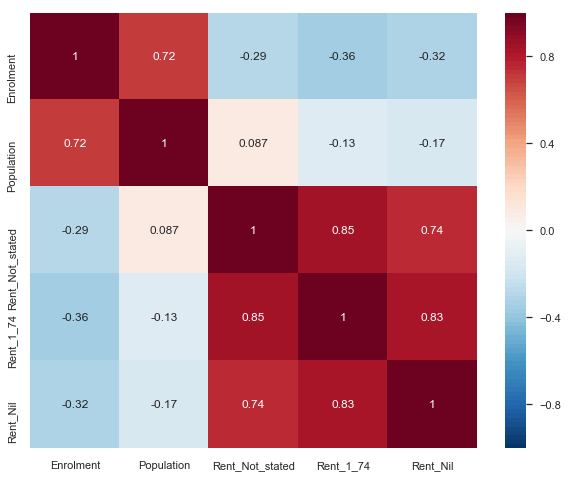

In [46]:
sns.set(rc={'figure.figsize':(10, 8)})

sns.heatmap(correlations.loc[feature_cols, feature_cols], 
            vmin=-1, vmax=1, annot=True,
            cmap=sns.color_palette("RdBu_r", 100), 
            xticklabels=True, yticklabels=True);

### Change data granularity

In [47]:
def bucket_data(cols, new_names, cut_offs):
    i = 0
    j = 0
    for new_name in new_names:
        df[new_name] = pre_election.loc[:, cols[i] : cut_offs[j]].sum(axis=1)
        print(cols[i], cut_offs[j])
        i = cols.index(cut_offs[j]) + 1
        j += 1

In [48]:
df = pd.DataFrame(index=pre_election.index)

###### Number of children in a family

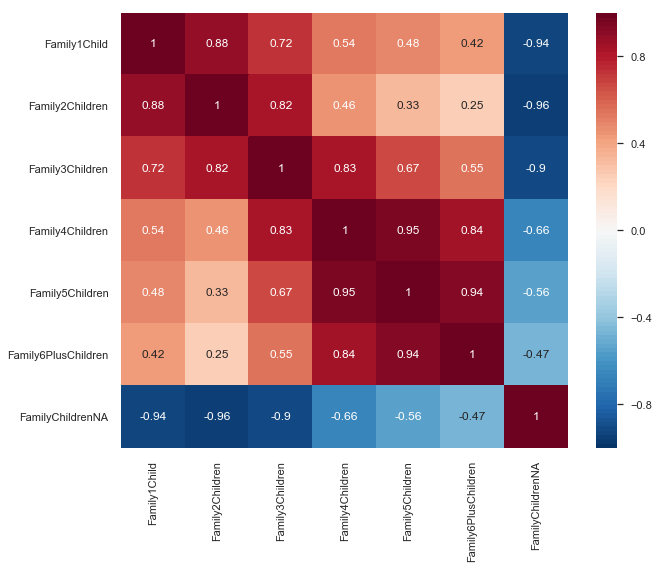

In [49]:
sns.heatmap(pre_election[fam_cols].corr(), 
            vmin=-1, vmax=1, annot=True,
            cmap=sns.color_palette("RdBu_r", 100), 
            xticklabels=True, yticklabels=True);

In [50]:
# Create 3 groups: families with 1 to 3 children, families with 4 to 6 children, 
# families/individuals without children. 

new_names = ['Family1to3Children', 'Family4to6Children', 'FamilyNoChildren']
cut_offs = ['Family3Children', 'Family6PlusChildren', 'FamilyChildrenNA']
bucket_data(fam_cols, new_names, cut_offs)

Family1Child Family3Children
Family4Children Family6PlusChildren
FamilyChildrenNA FamilyChildrenNA


###### Level of income per household

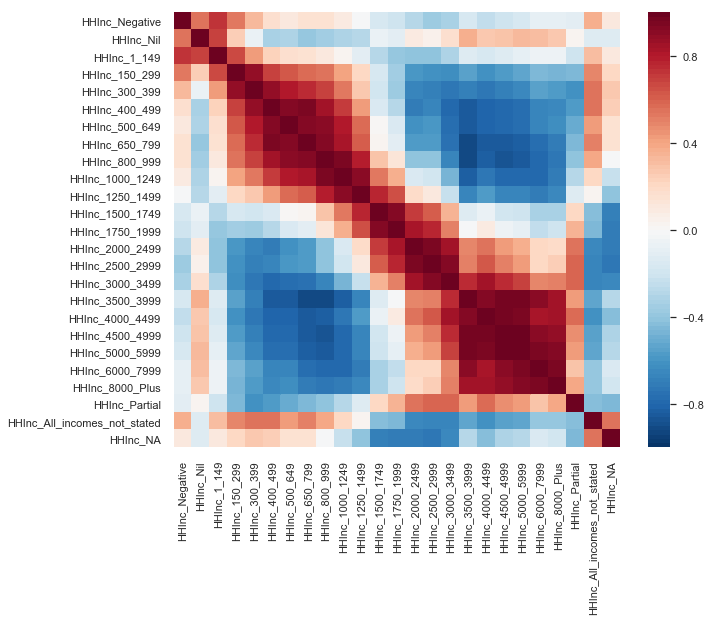

In [51]:
sns.heatmap(pre_election[inc_cols].corr(), 
            vmin=-1, vmax=1, annot=False,
            cmap=sns.color_palette("RdBu_r", 100), 
            xticklabels=True, yticklabels=True);

HHInc_Negative HHInc_150_299
HHInc_300_399 HHInc_1000_1249
HHInc_1250_1499 HHInc_2500_2999
HHInc_3000_3499 HHInc_8000_Plus


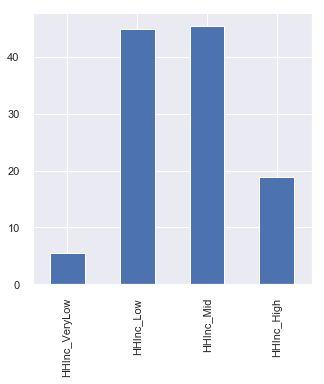

In [52]:
# Create 4 groups: households with very low, low, middle, and high income. 
# I'm not including columns with Partial, Not stated and NA income as they don't tell me much 
# and aren't correlated with the response variable anyway.

new_names = ['HHInc_VeryLow', 'HHInc_Low', 'HHInc_Mid', 'HHInc_High']
cut_offs = ['HHInc_150_299', 'HHInc_1000_1249', 'HHInc_2500_2999', 'HHInc_8000_Plus']
bucket_data(inc_cols, new_names, cut_offs)

df[new_names].sum().plot(kind='bar', figsize=(5, 5));

###### Amount of rent

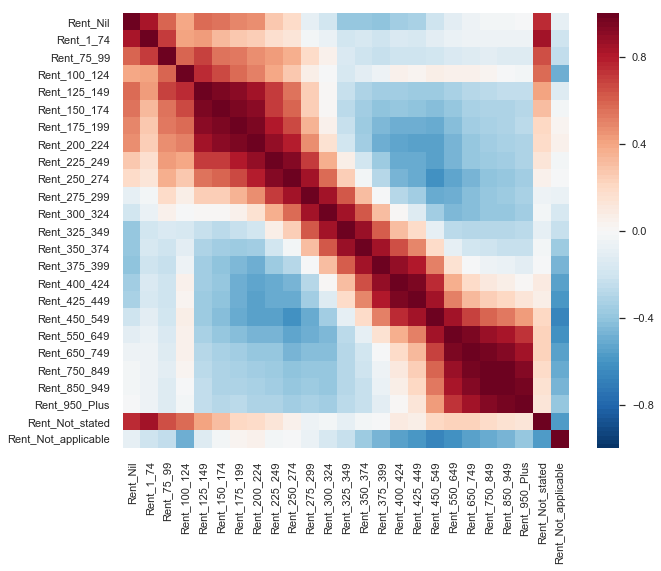

In [53]:
sns.heatmap(pre_election[rent_cols].corr(), 
            vmin=-1, vmax=1, annot=False,
            cmap=sns.color_palette("RdBu_r", 100), 
            xticklabels=True, yticklabels=True);

Rent_Nil Rent_100_124
Rent_125_149 Rent_275_299
Rent_300_324 Rent_450_549
Rent_550_649 Rent_950_Plus
Rent_Not_stated Rent_Not_stated
Rent_Not_applicable Rent_Not_applicable


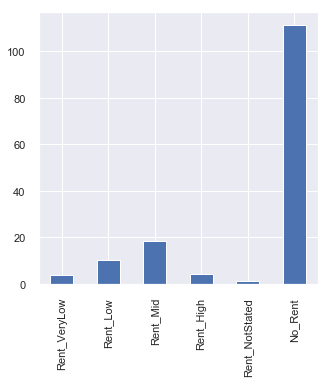

In [54]:
# # Create 4 groups: very low, low, middle, and high rent. 
# Both Not_stated and Not_applicable columns have
# relatively high correlation with the response variable.
new_names = ['Rent_VeryLow', 'Rent_Low', 'Rent_Mid', 'Rent_High', 'Rent_NotStated', 'No_Rent']
cut_offs = ['Rent_100_124', 'Rent_275_299', 'Rent_450_549', 'Rent_950_Plus', 'Rent_Not_stated', 'Rent_Not_applicable']
bucket_data(rent_cols, new_names, cut_offs)

df[new_names].sum().plot(kind='bar', figsize=(5, 5));

###### Age groups

Age_0_4 Age_15_19
Age_20_24 Age_30_34
Age_35_39 Age_60_64
Age_65_69 Age_100_Plus


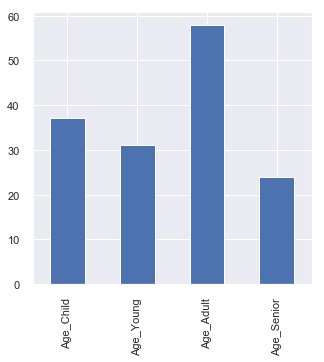

In [55]:
# Create 4 age groups: children (you must be at least 18 to vote in Australia),
# young adults, adults and seniours (average age at retirement in 2011 is was 61.4).
new_names = ['Age_Child', 'Age_Young', 'Age_Adult', 'Age_Senior']
cut_offs = ['Age_15_19', 'Age_30_34', 'Age_60_64', 'Age_100_Plus']
bucket_data(age_cols, new_names, cut_offs)

df[new_names].sum().plot(kind='bar', figsize=(5, 5));

###### Marital status

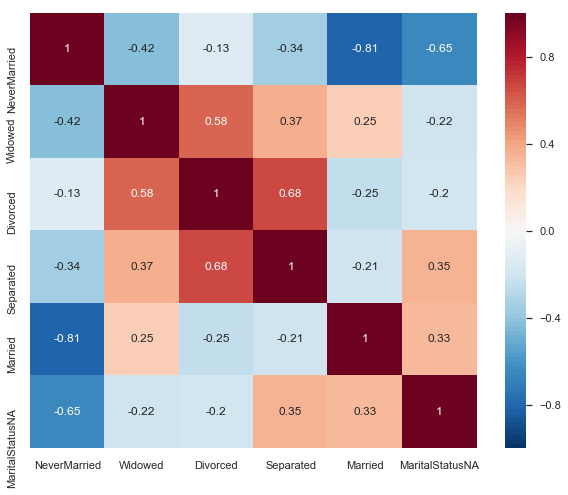

In [56]:
sns.heatmap(pre_election[mar_cols].corr(), 
            vmin=-1, vmax=1, annot=True,
            cmap=sns.color_palette("RdBu_r", 100), 
            xticklabels=True, yticklabels=True);

NeverMarried NeverMarried
Widowed Separated
Married Married


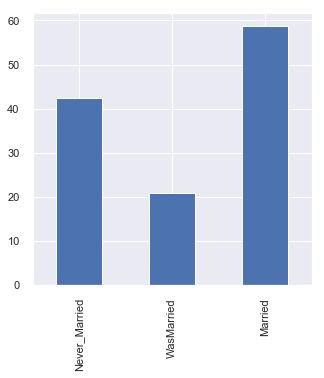

In [57]:
# Create 3 groups: people who have never been married, 
# those who were married before and are currently married.
new_names = ['Never_Married', 'WasMarried', 'Married']
cut_offs = ['NeverMarried', 'Separated', 'Married']
bucket_data(mar_cols, new_names, cut_offs)

df[new_names].sum().plot(kind='bar', figsize=(5, 5));

###### Higher education

In [58]:
# I only want to include those people who have a university degree.
df['Ed_Uni'] = pre_election.loc[:, 'Ed_Postgraduate_Degree' : 'Ed_Bachelor_Degree'].sum(axis=1)

###### Employment status

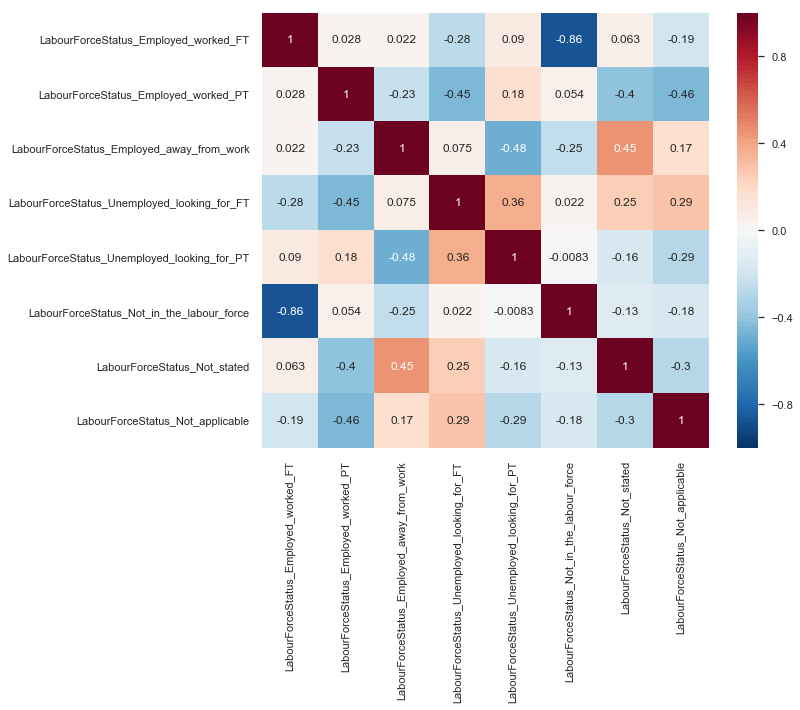

In [59]:
sns.heatmap(pre_election[empl_cols].corr(), 
            vmin=-1, vmax=1, annot=True,
            cmap=sns.color_palette("RdBu_r", 100), 
            xticklabels=True, yticklabels=True);

LabourForceStatus_Employed_worked_FT LabourForceStatus_Employed_away_from_work
LabourForceStatus_Unemployed_looking_for_FT LabourForceStatus_Unemployed_looking_for_PT
LabourForceStatus_Not_in_the_labour_force LabourForceStatus_Not_in_the_labour_force


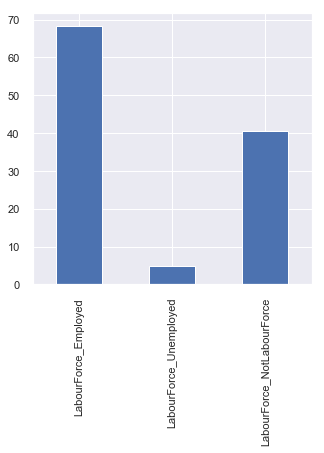

In [60]:
# Create 3 groups: currenly employed, unemployed and those
# who are not in the labour force (students, retired, carring for others, etc)
new_names = ['LabourForce_Employed', 'LabourForce_Unemployed', 'LabourForce_NotLabourForce']
cut_offs = ['LabourForceStatus_Employed_away_from_work', 
            'LabourForceStatus_Unemployed_looking_for_PT', 
            'LabourForceStatus_Not_in_the_labour_force']
bucket_data(empl_cols, new_names, cut_offs)

df[new_names].sum().plot(kind='bar', figsize=(5, 5));

###### Gender, enrolment, turnout

Obviously, `Population` and `Enrolment` are going to be highly correlated. Because `Enrolment` is a better predictor for my response variable I won't include `Population` in my new dataset. Also, it's enough to include only one gender, e.g. percentage of females.

In [61]:
cols = ['Female', 'Enrolment', 'Turnout']
df[cols] = pre_election.loc[:, cols]
print("The resulting dataframe has {} rows and {} columns.".format(df.shape[0], df.shape[1]))

The resulting dataframe has 150 rows and 27 columns.


In [62]:
df['NoShow'] = (100 - df.Turnout/df.Enrolment*100)
df.drop(['Enrolment', 'Turnout'], axis=1, inplace=True)

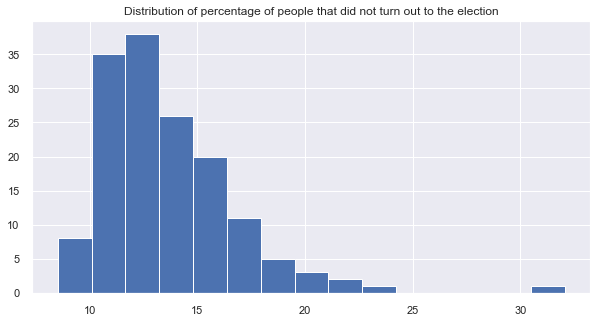

In [63]:
df.NoShow.hist(bins=15, figsize=(10, 5));
plt.title('Distribution of percentage of people that did not turn out to the election');

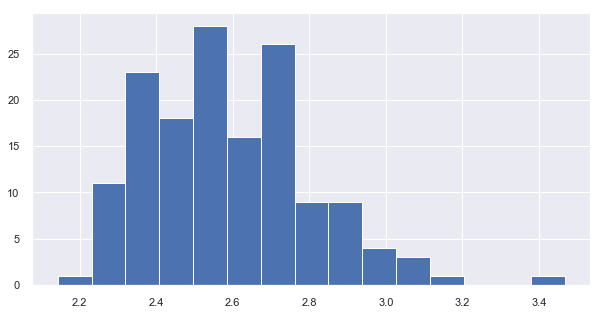

In [64]:
np.log(df.NoShow).hist(bins=15, figsize=(10, 5));

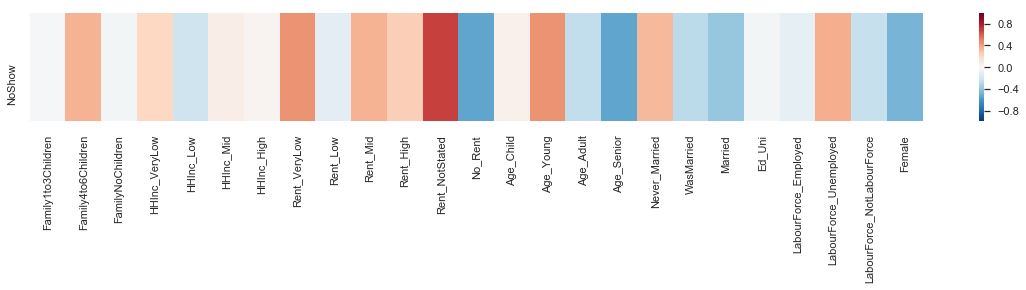

In [65]:
correlations = df.corr()

sns.set(rc={'figure.figsize':(20, 2)})

sns.heatmap(correlations[['NoShow']].drop('NoShow').T, 
            vmin=-1, vmax=1,
            cmap=sns.color_palette("RdBu_r", 100), 
            xticklabels=True, yticklabels=True);

In [66]:
feature_cols = abs(correlations.NoShow).drop('NoShow').sort_values(ascending=False).head(7).index.to_list()
feature_cols

['Rent_NotStated',
 'No_Rent',
 'Age_Senior',
 'Female',
 'Rent_VeryLow',
 'Age_Young',
 'Married']

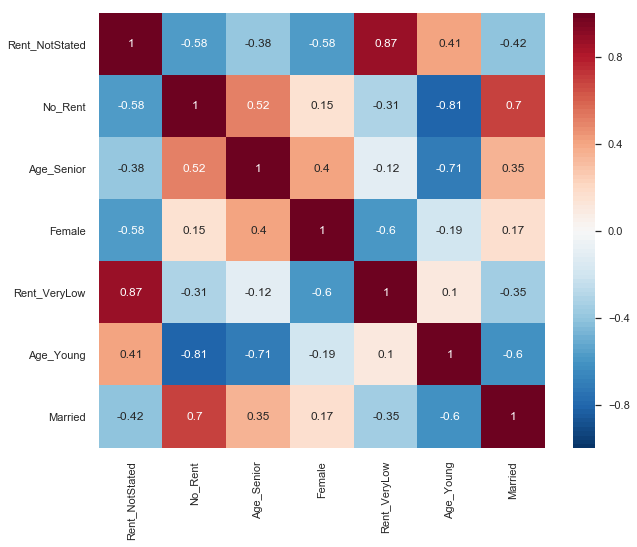

In [67]:
sns.set(rc={'figure.figsize':(10, 8)})

sns.heatmap(correlations.loc[feature_cols, feature_cols], 
            vmin=-1, vmax=1, annot=True,
            cmap=sns.color_palette("RdBu_r", 100), 
            xticklabels=True, yticklabels=True);

### Build a simple linear regression model

###### Define the feature map and the response variable

In [68]:
# Use only features that are highly correlated with the response variable
X = df[feature_cols]

# Use highly correlated features and state variables
# X = pd.concat([df[feature_cols], state_dummies], axis=1)

y = df.NoShow

print(X.shape, y.shape)

(150, 7) (150,)


###### Train-test split

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, random_state=)
print(X_train.shape, X_test.shape)

SyntaxError: invalid syntax (<ipython-input-69-8fddaaf3f660>, line 1)

###### Standardise the data

In [ ]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

###### Linear regression

In [ ]:
lin_reg = LinearRegression(fit_intercept=True)
lin_reg.fit(X_train_scaled, y_train)

print(lin_reg.intercept_)
print(lin_reg.coef_)

In [ ]:
y_pred = lin_reg.predict(X_test_scaled)

rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
print("Testing RMSE:", rmse_test)

In [ ]:
plt.scatter(y_test, y_pred);

###### Null RMSE

In [ ]:
print("Null RMSE:", np.sqrt(mean_squared_error(y_test, y_test.apply(lambda x: np.mean(y_train)))))

###### Apply log transformation  to `y` to reduce variance

In [ ]:
# Use only features that are highly correlated with the response variable
X = df[feature_cols]

# Use highly correlated features and state variables
# X = pd.concat([df[feature_cols], state_dummies], axis=1)

# Log transformation
y = np.log(df.NoShow)

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, random_state=1)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lin_reg = LinearRegression(fit_intercept=True)
lin_reg.fit(X_train_scaled, y_train)

y_pred = lin_reg.predict(X_test_scaled)

rmse_test = np.sqrt(mean_squared_error(np.exp(y_test), np.exp(y_pred)))
print("Testing RMSE:", rmse_test)

print("Null RMSE:", np.sqrt(mean_squared_error(np.exp(y_test), y_test.apply(lambda x: np.mean(np.exp(y_train))))))

### Build a polynomial regression

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

X = df[feature_cols]
y = df.NoShow

train_rmse = []
val_rmse = []

degrees = range(1,4)

for degree in degrees:
    # Polynomial features
    poly_features = PolynomialFeatures(degree=degree, interaction_only=True, include_bias=False)
    X_poly = poly_features.fit_transform(X)
    print("Polynomial features:", X_poly.shape)

    # Create train-validation-test split
    X_train, X_test, y_train, y_test = train_test_split(X_poly, y, shuffle=True, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, shuffle=True, random_state=42)
    print("Train-validation-test split:", X_train.shape, X_val.shape, X_test.shape)

    # Standardise the data
    scaler = StandardScaler()

    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    # Linear Regression
    lin_reg = LinearRegression()
    lin_reg.fit(X_train_scaled, y_train)

    y_pred = lin_reg.predict(X_val_scaled)
    
    train_rmse.append(np.sqrt(mean_squared_error(y_train, lin_reg.predict(X_train_scaled))))
    val_rmse.append(np.sqrt(mean_squared_error(y_val, y_pred)))

In [ ]:
column_dict = {'d': degrees, 
               'Training RMSE' : train_rmse, 
               'Validation RMSE' : val_rmse}

rmse = pd.DataFrame(column_dict).set_index('d').sort_index(ascending=False)
rmse.plot();

In [ ]:
rmse.sort_values(by='Validation RMSE')

The lowest RMSE is achieved including only interaction terms up to degree = 2. Does it mean we should use degree 2?

###### Test the model

In [ ]:
# Polynomial features
poly_features = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_poly = poly_features.fit_transform(X)

# Create train-test split
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, shuffle=True, random_state=42)

# Standardise the data
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Linear Regression
lin_reg = LinearRegression()
lin_reg.fit(X_train_scaled, y_train)

y_pred = lin_reg.predict(X_test_scaled)
    
print("Testing RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

### Same using cross validation

> Strictly speaking the approach below is incorrect. Why?

In [ ]:
X = df[feature_cols]
y = df.NoShow

degrees = range(1,4)

for degree in degrees:
    # Polynomial features
    poly_features = PolynomialFeatures(degree=degree, interaction_only=True, include_bias=False)
    X_poly = poly_features.fit_transform(X)

    # Create train-validation-test split
    X_train, X_test, y_train, y_test = train_test_split(X_poly, y, shuffle=True, random_state=42)

    # Standardise the data
    scaler = StandardScaler()

    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Linear Regression
    lin_reg = LinearRegression()

    # 5-fold cross-validation
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(lin_reg, X_train_scaled, y_train, cv=cv, scoring='neg_mean_squared_error')

    # Cross Validation
    print("Polynomial regression with degree {}. Mean RMSE for all folds is {}".format(degree,
                                                                                       np.mean(np.sqrt(-scores))))

However, when performing train/test split we always standartise the data after splitting it as we want to avoid leaking any information from the test set. 

Ideally, with cross-validation the same idea applies: after splitting a dataset into $k$ folds we want to calculate statisticss on $(k-1)$ subsets and apply it to the last $k$-th validation subset.

In [ ]:
X = df[feature_cols]
y = df.NoShow

degrees = range(1,4)

for degree in degrees:
    # Polynomial features
    poly_features = PolynomialFeatures(degree=degree, interaction_only=True, include_bias=False)
    X_poly = poly_features.fit_transform(X)

    # Create train-validation-test split
    X_, X_test, y_, y_test = train_test_split(X_poly, y, shuffle=True, random_state=42)
    
    # 5-fold cross-validation
    cv = KFold(n_splits=5, shuffle=True)
    
    scores =[]
    
    for train_index, val_index in cv.split(X_, y_):
        scaler = StandardScaler()

        X_train_scaled = scaler.fit_transform(X_[train_index])
        X_val_scaled = scaler.transform(X_[val_index])

        # Linear Regression
        lin_reg = LinearRegression()
        lin_reg.fit(X_train_scaled, y_.iloc[train_index])

        y_pred = lin_reg.predict(X_val_scaled)
    
        scores.append(np.sqrt(mean_squared_error(y_.iloc[val_index], y_pred)))
        
    print("Polynomial regression with degree {}. Mean RMSE for all folds is {}".format(degree, np.mean(scores)))

### Create a pipeline and run cross-validation

A `Pipeline` is an object that sequentially applies a list of transforms and a final estimator. Let's create a pipeline that first scales our data and then fits a linear regression model.

```bash
pipeline = Pipeline([
        ("scaler", StandardScaler()), 
        ("lin_reg", LinearRegression())
    ])
```

Now we can call `cross_val_score` on unscaled data passing `pipeline` as an estimator.

```bash
scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')
```

According to [scikit-learn documentation](https://scikit-learn.org/stable/modules/cross_validation.html#) a `Pipeline` object provides the correct behaviour under cross-validation. In particular, if you use the `StandardScaler` as a step inside a `Pipeline` then `scikit-learn` will internally do the job for you.

What happens can be discribed as follows:

* Step 0: The data is split into **training** set and **test** set according to the `cv` parameter that you specified in the `cross_val_score`.
* Step 1: the scaler is fitted on the **training** data
* Step 2: the scaler transforms **training** data
* Step 3: the models are fitted/trained using the transformed **training** data
* Step 4: the scaler is used to transform the **test** data
* Step 5: the trained models predict using the transformed **test** data

via [stackoverflow](https://stackoverflow.com/questions/51459406/apply-standardscaler-in-pipeline-in-scikit-learn-sklearn)

In [ ]:
X = df[feature_cols]
y = df.NoShow

degrees = range(1,4)

for degree in degrees:
    # Polynomial features
    poly_features = PolynomialFeatures(degree=degree, interaction_only=False, include_bias=False)
    X_poly = poly_features.fit_transform(X)
    
    # Create train-test split
    X_train, X_test, y_train, y_test = train_test_split(X_poly, y, shuffle=True, random_state=42)

    # Create a pipeline to first standardise the data 
    # and then fit a linear regression model
    pipeline = Pipeline([
        ("scaler", StandardScaler()), 
        ("lin_reg", LinearRegression())
    ])
    
    # 5-fold cross-validation
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')

    print("Polynomial regression with degree {}. Mean RMSE for all folds is {}".format(degree,
                                                                                       np.mean(np.sqrt(-scores))))

### Regularisation

In [ ]:
# Use only features that are highly correlated with the response variable
X = df[feature_cols]
y = df.NoShow

poly_features = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
X_poly = poly_features.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_poly, y, shuffle=True, random_state=1)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Train-test split:", X_train.shape, X_test.shape)

###### Unregularised linear regression

In [ ]:
lin_reg = LinearRegression(fit_intercept=True)
lin_reg.fit(X_train_scaled, y_train)

print("Coefficients estimated by linear regression:\n", lin_reg.coef_)

y_pred = lin_reg.predict(X_test_scaled)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
print("\nTesting RMSE:", rmse_test)

###### Ridge regression
The hyperparameter $\alpha$ controls how much you want to regularize the model. If $\alpha = 0$ then Ridge Regression is just Linear Regression. If $\alpha$ is very large, then all weights end up very close to zero and the result is a flat line going through the data’s mean.

In [ ]:
from sklearn.linear_model import Ridge

ridge_reg = Ridge(alpha=100)
ridge_reg.fit(X_train_scaled, y_train)

print("Coefficients estimated by Ridge regression:\n", ridge_reg.coef_)

y_pred = ridge_reg.predict(X_test_scaled)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
print("\nTesting RMSE:", rmse_test)

###### Lasso regression
Parameter $\alpha$ is a constant that multiplies the $L_1$ term. Default value is 1.0. $\alpha = 0$ is equivalent to an ordinary least square, solved by the `LinearRegression` object. An important characteristic of `Lasso Regression` is that it tends to completely eliminate the weights of the least important features (i.e., set them to zero)

In [ ]:
from sklearn.linear_model import Lasso

lasso_reg = Lasso(alpha=0.3)
lasso_reg.fit(X_train_scaled, y_train)

print("Coefficients estimated by Lasso regression:\n", lasso_reg.coef_)

y_pred = lasso_reg.predict(X_test_scaled)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
print("\nTesting RMSE:", rmse_test)

## Binary classification 

**Objective: Using the available data predict which party will receive more votes.** 

**Basic level**
- Explore the relationships between the features.
- Select or engineer features that are assocciated with the response variable.
- Create one-hot vectors for categorical variables.
- Create a train/test split (try different ratios).
- Standartise the dataset if needed. 
- Train and evaluate a binary classification model.
- Calculate null accuracy and compare your model against it.

**Intermediate level**
- Use kNN model for binary classification and compare its performance with Logistic Regression.
- Output confusion matrix to see what observations are misclassified.
- Create train-validation-test split to tune your model.

**Advanced level**
- Use three-way split with cross-validation.
- Plot a ROC curve.
- Perform multiclass classification to predict the Winning Party. For example, you can predict if the winning party is ALP, LP or Other.
- Generate synthetic data.

### Target variable

In [ ]:
election.WinningParty.value_counts().plot(kind='bar', figsize=(15, 5));

###### Create a new response variable for binary classification

In [ ]:
election['two_party'] = 'ALP'
election.loc[election.LP + election.LNP + election.NP > election.ALP,'two_party'] = 'Coalition'

In [ ]:
df['two_party'] = election.two_party
df.two_party.value_counts().plot(kind='bar', figsize=(15, 5));

### Build a classification model

###### Define the feature map and the response variable

In [ ]:
# Reduced census data, state variables and NoShow
X = pd.concat([df.drop('two_party', axis=1), state_dummies], axis=1)
y = df.two_party

print(X.shape, y.shape)

###### Train-test split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, random_state=1)
print(X_train.shape, X_test.shape)

###### Standardise the data

In [ ]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

###### Logistic regression

In [ ]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(solver='lbfgs')
log_reg.fit(X_train_scaled, y_train)

print(log_reg.intercept_)
print(log_reg.coef_)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

y_pred = log_reg.predict(X_test_scaled)

print("Testing Accuracy:", accuracy_score(y_test, y_pred))
print("Testing F score:", f1_score(y_test, y_pred, pos_label='ALP'))

###### Null Accuracy

In [ ]:
most_freq_class = y_train.value_counts().index[0]
print("Most frequent class:", most_freq_class)

n_most_freq = y_test.value_counts()[most_freq_class]
print("Null accuraccy:", n_most_freq / len(y_test))

###### kNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=15)
knn.fit(X_train_scaled, y_train)

In [ ]:
y_pred = knn.predict(X_test_scaled)

print("Testing Accuracy:", accuracy_score(y_test, y_pred))
print("Testing F score:", f1_score(y_test, y_pred, pos_label='ALP'))

In [ ]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_pred)

###### Tune kNN model

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, shuffle=True, random_state=1)
print("Train-validation-test split:", X_train.shape, X_val.shape, X_test.shape)

# Standardise the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [ ]:
def choose_k():
    # Define maximum number of neighbours
    k_max = min(101, y_train.shape[0])
    k_range = list(range(1, k_max))
    
    train_error = []
    val_error = []

    # Find training and test accuracy for all values of k between 1 and 100 (inclusive).
    for k in k_range:

        # Instantiate the model with the current K value.
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train_scaled, y_train)

        # Calculate training error (error = 1 - accuracy).
        y_pred_class = knn.predict(X_train_scaled)
        train_accuracy = accuracy_score(y_train, y_pred_class)
        train_error.append(1 - train_accuracy)

        # Calculate testing error.
        y_pred_class = knn.predict(X_val_scaled)
        val_accuracy = accuracy_score(y_val, y_pred_class)
        val_error.append(1 - val_accuracy)
            
    return k_range, train_error, val_error

In [ ]:
k_range, train_error, val_error = choose_k()
column_dict = {'k': k_range, 
               'Training error' : train_error, 
               'Validation error' : val_error}

errors = pd.DataFrame(column_dict).set_index('k').sort_values('Validation error')
errors.head()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, random_state=1)

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

knn = KNeighborsClassifier(n_neighbors=4)
knn.fit(X_train_scaled, y_train)

y_pred = knn.predict(X_test_scaled)

print("Testing Accuracy:", accuracy_score(y_test, y_pred))
print("Testing F score:", f1_score(y_test, y_pred, pos_label='ALP'))

print("\nClasses:", knn.classes_)

confusion_matrix(y_test, y_pred)

###### ROC curve

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

y_proba = knn.predict_proba(X_test_scaled)
fpr, tpr, threshold = roc_curve(y_test, y_proba[:,0], pos_label='ALP')

plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], 'k--')
plt.axis([0, 1, 0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Posiitve Rate');

## Multiclass Classification

### Create target variable

In [ ]:
election['two_party'] = 'Other'
election.loc[election.WinningParty=='ALP', 'two_party'] = 'ALP'
election.loc[(election.WinningParty=='LP') | 
             (election.WinningParty=='LNP') | 
             (election.WinningParty=='NP'), 
             'two_party'] = 'Coalition'

In [ ]:
df['two_party'] = election.two_party
df.two_party.value_counts().plot(kind='bar', figsize=(15, 5));

In [ ]:
df.two_party.value_counts()

### Build a classification model

###### Define the feature map and the response variable

In [ ]:
# feature_cols = ['perc_wealthy', 'perc_emplFT']
# X = pd.concat([election[feature_cols], state_dummies], axis=1)
# Reduced census data, state variables and NoShow
X = pd.concat([df.drop('two_party', axis=1), state_dummies], axis=1)
y = df.two_party

print(X.shape, y.shape)

###### Synthesise data using SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(k_neighbors=4)
smote

In [ ]:
X_sm, y_sm = smote.fit_sample(X, y)

print("\nAfter synthesing new observations the balanced dataset has {} rows and {} columns.\n"
      .format(X_sm.shape[0], X_sm.shape[1]))

df_smote = pd.concat([pd.DataFrame(X_sm, columns=X.columns), 
                      pd.DataFrame(y_sm, columns=['two_party'])],
                     axis=1).sort_values(by='two_party')

In [ ]:
df_smote.two_party.value_counts().plot(kind='bar', figsize=(15, 5));

###### Train-test split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, shuffle=True, random_state=1)
print(X_train.shape, X_test.shape)

###### Standardise the data

In [ ]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

###### kNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=15)
knn.fit(X_train_scaled, y_train)

In [ ]:
y_pred = knn.predict(X_test_scaled)

print("Testing Accuracy:", accuracy_score(y_test, y_pred))
print("Testing F score:", f1_score(y_test, y_pred, average='macro'))

In [ ]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_pred)